# Library import

In [3]:
from simmem import *
from Sembrane_calculator import *

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.interpolate import interp1d

from scipy.optimize import minimize
from scipy import interpolate

parameters = {'axes.labelsize': 17,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.rcParams['font.family'] = 'arial'
from itertools import product

# Membrane property

## self-diffusivity

In [5]:
# data import
msd_crop = cropmsd('msd_self_methane_0.dat')

# Calculate self-diffusivity using MSD
D_mem = self_diff(msd_crop)

Self diffusiivty (m^2/s):  4.18764738667886e-07


## Permeance

In [9]:
# Membrane property
P = 6                         # Gas pressure (bar)
q = 6.4                       # Gas uptake (mol/kg)
rho = 1320e-9                 # Material density (kg/mm^3)

# Fiber sizing
D_inner = 100*1e-1            # Membrane inner diameter (mm)
D_outer = 250*1e-1            # Membrane outer diameter (mm)
thickness = (D_outer-D_inner)/2

# Calculate permeance
a_mem = permeance(P, D_mem*1e6, q, rho, thickness)
print('Permeance (mol/(mm2 bar s)): ', a_mem)

Permeance (mol/(mm2 bar s)):  7.861610027258448e-08


# Membrane process

## Module design

In [34]:
n_component = 4               # number of gas components
configureation = 'CTFS'       # module configureation (Counter-current / feed-shell side)
L = 0.6*1e3                   # fiber length (mm)
D_module = 0.1*1e3            # Module diameter (mm)
N_fiber = 60000               # number of fiber (-)

N = 1000                      # number of nodes (-)

Mem_proc = MembraneProc(configureation, L, D_module, N_fiber, 
                        n_component, n_node = N)
print(Mem_proc)

[[Current information included here]] 
Design          : True
Membrane_info   : False
Gas_prop_info   : False
Mass_trans_info : False
BoundaryC_info  : False
InitialC_info   : False



## Membrane property

In [35]:
a_i = np.array([1.60e-11, 6.96e-12, 5.33e-13, 6.67e-13]) #Permeance(mol/(mm2 bar s))
D_inner = 200*1e-3            # Membrane inner diameter (mm)
D_outer = 250*1e-3            # Membrane outer diameter (mm)

Mem_proc.membrane_info(a_i, D_inner, D_outer)
print(Mem_proc)

[[Current information included here]] 
Design          : True
Membrane_info   : True
Gas_prop_info   : False
Mass_trans_info : False
BoundaryC_info  : False
InitialC_info   : False



## Gas & mass transfer property

In [36]:
# Gas property
Mw_i = np.array([2e-2, 44e-3, 16e-3, 28e-3])                 # molar weight (kg/mol)
rho_i = np.array([0.08988, 1.98, 0.657, 1.14 ])*1e-9         # density (kg/mm3)
mu_i = np.array([0.94e-5, 0.0155e-3, 0.011e-3, 1.83567e-5])  # viscosity (Pa s)

Mem_proc.gas_prop_info(Mw_i, mu_i, rho_i)
print(Mem_proc)

# Mass transfer property
k_mass = 1e-1              # Mass transfer coeff. (mm/s)
Mem_proc.mass_trans_info(k_mass)
print(Mem_proc)

[[Current information included here]] 
Design          : True
Membrane_info   : True
Gas_prop_info   : True
Mass_trans_info : False
BoundaryC_info  : False
InitialC_info   : False

[[Current information included here]] 
Design          : True
Membrane_info   : True
Gas_prop_info   : True
Mass_trans_info : True
BoundaryC_info  : False
InitialC_info   : False



## Boundary & initial condition

In [37]:
# Boundary conditions
P_feed = 20                                    # pressure of feed side (bar)
T = 313.15                                     # temperature (K)
F_feed = 0.03                                  # feed flow rate (mol/s)
y_feed = np.array([0.75, 0.2, 0.04, 0.01])     # mole fraction (H2, CO2, CH4, CO)

Mem_proc.boundaryC_info(y_feed, P_feed, F_feed, T)
print(Mem_proc)

# Initial condition
Mem_proc.initialC_info()
print(Mem_proc)

[[Current information included here]] 
Design          : True
Membrane_info   : True
Gas_prop_info   : True
Mass_trans_info : True
BoundaryC_info  : True
InitialC_info   : False

[[Current information included here]] 
Design          : True
Membrane_info   : True
Gas_prop_info   : True
Mass_trans_info : True
BoundaryC_info  : True
InitialC_info   : True



## Simulation run

In [38]:
results = Mem_proc.run_mem()
error = Mem_proc.MassBalance()

Simulation started
Simulation is completed without warning
Mass balance (error %):  5.781080330621689e-14


# Results analysis

## Techno-economic analysis

In [39]:
# Economic analysis parameters
MODP = 10/1000000       # Total membrane module cost (USD/ft2)
mem_life = 4            # membrane life (years)
t = 5                   # project year (yr)
r = 0.1                 # interest rate (%)
R_gas = 8.314           # Gas constant (J/K mol)
h_ratio = 1.4           # Heat capacity ratio (-)
effi_ref = 0.8          # compressor efficiency (-)

# total annual cost
TAC = Mem_proc.CalculTAC(MODP, mem_life, t, r, h_ratio, effi_ref)   # USD/yr
print(TAC, 'USD/yr')

# energy consumption
E_comp = Mem_proc._CalculCompr(h_ratio, effi_ref)       # kW
print(E_comp[0], 'kW')

1471.0817012309603 USD/yr
0.3589474937456787 kW


# Visualization

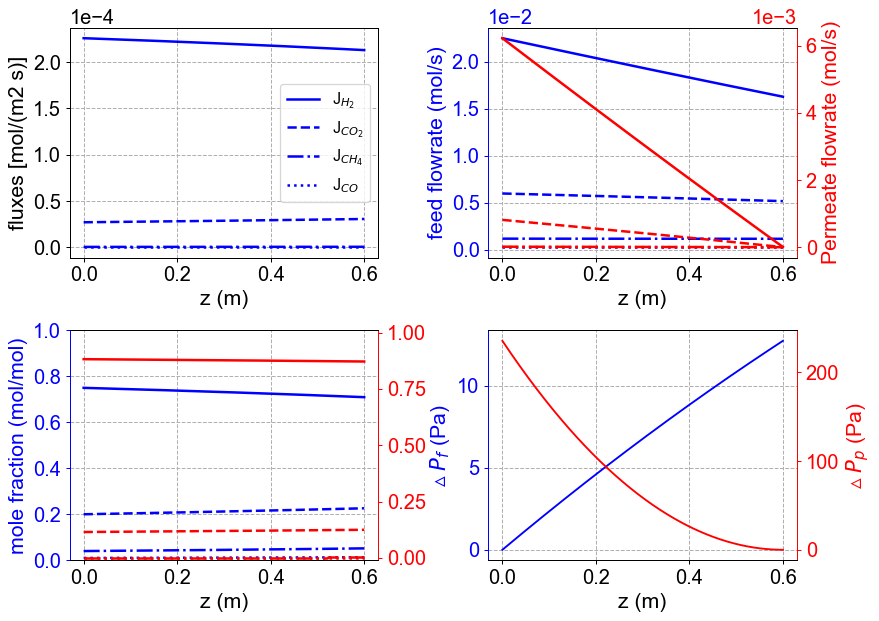

In [40]:
Mem_proc.PlotResults(component=['{H_2}','{CO_2}', '{CH_4}', '{CO}'])